In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [3]:
#writer = SummaryWriter('runs/adverserial_attack_experiment_1')

In [2]:
# pretrained model 불러오기
model = models.resnet101(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# 데이터셋 불러오기
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [13]:
# 이미지 불러오기
img = Image.open("./imagenet_samples/corgie.jpg")

In [15]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양: ", img_tensor.size())

이미지 텐서 모양:  torch.Size([1, 3, 224, 224])


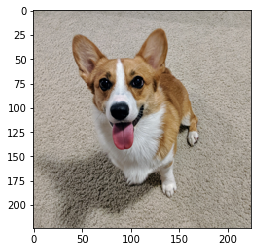

In [16]:
# 시각화를 위해 numpy matrix 변환
# [1, 3, 224, 224] -> [3, 224, 224]
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0, 2).transpose(0, 1).numpy()

plt.imshow(original_img_view)

In [21]:
output = model(img_tensor)

prediction = output.max(1, keepdim=False)[1]
prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


In [24]:
def fgsm_attack(image, epsilon, gradient):
    # gradient 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    
    # 이미지의 각 픽셀값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    
    #[0, 1] 범위를 벗어나는 값 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [25]:
img_tensor.requires_grad_(True)
output = model(img_tensor)

# loss 
loss = F.nll_loss(output, torch.tensor([263]))    # 263은 웰시코기

# gradient
model.zero_grad()
loss.backward()

# backward를 함으로써, img_tensor의 grad.data 변수에 입력 이미지의 기울기가 저장됨.
# 앞서 정의한 fgsm_attack을 호출함. epsilon값은 0, 1 사이의 어느 값도 괜찮음.

In [44]:
# gradient 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.1
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [45]:
attack_output = model(perturbed_data)

perturbed_prediction = attack_output.max(1, keepdim=True)[1]
perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 273
레이블 이름: dingo, warrigal, warragal, Canis dingo


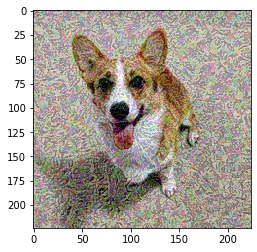

In [46]:
# visualization

perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0, 2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

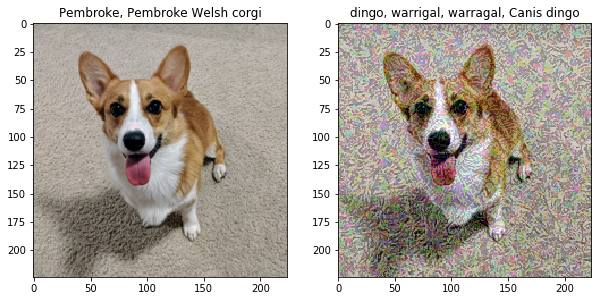

In [47]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# original
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# fake
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()

In [43]:
# writer.add_graph(model, input_to_model=img_tensor)
# writer.close()